# Time model 

The court is cut into different cell. For each cell, we would like to know the closest player taking into account inertia. Mathematical development are avalaible in the file *Closest_player_to_a_point*. Here we the results of this model, particularly, how visually we can see that it takes inertia into account

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import json
import space as sp
from data_extracter import json_extracter
import pandas as pd

data,events=json_extracter('data/game1.json')

## Function Time_to_point
This function returns the time required to go from point a to point b with initial speed v. F is the value of the force granted to a player (per unit of mass). A previous investigation has told that F should be closed to 10m/s [1].

In [2]:
def time_to_point(a,b,v,F=10*3.28):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i]>0:
                return times[i].real
    print('error')
    return times[0]

## Example of trajectories with our model

The black arrow represents the force and the green arrow the initial speed. 

In [241]:
def path(a,b,v,F=10*3.28,nb_points=100):
    tf=time_to_point(a,b,v,F)
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return(lx,ly,Fx,Fy,tf)

In [242]:
def print_path(a,b,v,F=10*3.28):
    lx,ly,Fx,Fy,tf=path(a,b,v,F)
    plt.plot(lx,ly)
    plt.plot(a[0],a[1], 'ro')
    plt.plot(b[0],b[1], 'bo')
    plt.arrow(a[0],a[1],Fx/10,Fy/10,shape='full',lw=1.5,head_width=0.2)
    plt.arrow(a[0],a[1],v[0],v[1],shape='full',lw=1.5,head_width=0.2, color='g')
    plt.xlim(min(v[0],Fx/10,0)-2,max(v[0],Fx/10,0)+2)
    plt.ylim(min(v[1],Fy/10,0)-2,max(v[1],Fy/10,0)+2)
    plt.show()

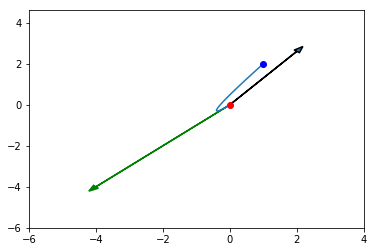

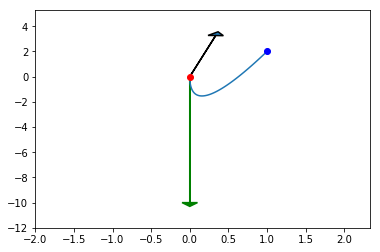

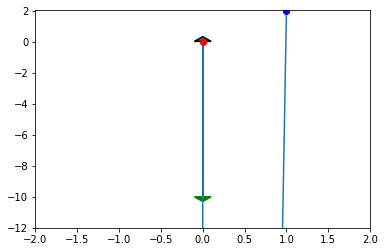

In [184]:
plt.subplots()
print_path(np.array([0,0]),np.array([1,2]),np.array([-4,-4]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]))
print_path(np.array([0,0]),np.array([1,2]),np.array([0,-10]),F=0.1*3.28)

## Comparing our trajectories to real ones

The aim is to adjust the value of F. We take the position $a$ of a player at a time t. We look where he is (point $b$) at the time t+$\Delta$t and the trajectory he made during $\Delta$t. With our model, we compute the trajectory to go from $a$ to $b$ and look at the difference between both trajectories. We iterate several time and we do this for several value of F. Then, we can adjust our F value to the one that leads to less errors.

In [153]:
def one_trajectory_error(lx,ly,lxreal,lyreal):
    MSE=0
    for x,y,xreal,yreal in zip(lx,ly,lxreal,lyreal):
        delta=(np.linalg.norm(np.array([xreal-x,yreal-y])))**2
        MSE+=delta
    return MSE
    

In [185]:
def players_ball_speed_position(moment1,moment2):
    team1,team2,ball =[],[],[]
    
    dt=0.04
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[i][2:4])
            mom_infos['ball']['z']=moment1[i][4]
            mom_infos['ball']['v']=np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
    return(mom_infos)

In [309]:
def event_trajectory_error(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    errors=[]
    times=[]
    for f in np.arange(5,15,0.5):
        error=[]
        TF=[]
        for mom_id in range(len(moments)-round(t/0.04)-1):
            err=0
            moment1=moments[mom_id][5]
            moment2=moments[mom_id+1][5]
            moment1f=moments[mom_id+round(t/0.04)][5]
            moment2f=moments[mom_id+round(t/0.04)+1][5]
            mom_infos=players_ball_speed_position(moment1,moment2)
            mom_infos_final=players_ball_speed_position(moment1f,moment2f)
            LX={}
            LY={}
            LXREAL={}
            LYREAL={}
            
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                b=mom_infos_final['team1'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                b=mom_infos_final['team2'][player]['xy']
                lx,ly,Fx,Fy,tf=path(a,b,v,f*3.28,round(t/0.04))
                LX[player]=lx
                LY[player]=ly
                TF.append(tf-t)
            
            for player in mom_infos['team1'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for player in mom_infos['team2'].keys():
                LXREAL[player]=[]
                LYREAL[player]=[]
            
            for i in range(round(t/0.04)+1):
                mom1=moments[mom_id+i][5]
                mom2=moments[mom_id+i+1][5]
                mom_infos=players_ball_speed_position(mom1,mom2)
                for player in mom_infos['team1'].keys():
                    LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                    LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
                for player in mom_infos['team2'].keys():
                    LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                    LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
            
            for player in LX.keys():
                #if mom_id==20 and player=='2225':
                    #print('f:',f)
                    #print(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))
                    #plt.plot(LX[player],LY[player],'b--')
                    #plt.plot(LXREAL[player],LYREAL[player],'r-')
                    #plt.show()
                error.append(one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player]))

        errors.append(error)
        forces.append(f)
        times.append(TF)
    return(errors,forces,times)
        
            
        

In [319]:
errors,forces,times=event_trajectory_error(0,0.5)

In [320]:
df=pd.DataFrame(errors,index=forces)
df.T.describe()

,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000
mean,0.250692,0.270538,0.289944,0.309194,0.327346,0.344825,0.361606,0.377781,0.393409,0.408531,0.423178,0.437380,0.451160,0.464542,0.477547,0.490194,0.502500,0.514481,0.526153,0.537531
std,0.289846,0.308556,0.328306,0.348158,0.366754,0.385143,0.403211,0.420947,0.438364,0.455471,0.472276,0.488786,0.505008,0.520948,0.536611,0.552002,0.567128,0.581993,0.596604,0.610966
min,0.000773,0.000784,0.000793,0.000801,0.000809,0.000815,0.000822,0.000827,0.000832,0.000837,0.000842,0.000846,0.000850,0.000854,0.000857,0.000861,0.000864,0.000867,0.000870,0.000872
25%,0.058750,0.064316,0.068970,0.073310,0.076929,0.080674,0.083629,0.087662,0.089626,0.091915,0.094102,0.095659,0.097562,0.100728,0.102450,0.103821,0.106078,0.107311,0.108325,0.109854
50%,0.129386,0.142620,0.154029,0.167915,0.181827,0.190913,0.202792,0.211682,0.221784,0.232071,0.242438,0.250082,0.259101,0.268205,0.274467,0.278684,0.284520,0.293160,0.300776,0.307437
75%,0.311650,0.328691,0.352599,0.377338,0.398561,0.422218,0.439947,0.463704,0.491366,0.510677,0.534926,0.553396,0.568089,0.577975,0.591397,0.611160,0.621815,0.634244,0.648643,0.663227
max,1.940167,2.045177,2.142779,2.234280,2.320601,2.402431,2.480301,2.554634,2.625778,2.694021,2.759609,2.822752,2.883634,2.942416,2.999240,3.054232,3.107507,3.159167,3.209306,3.258008


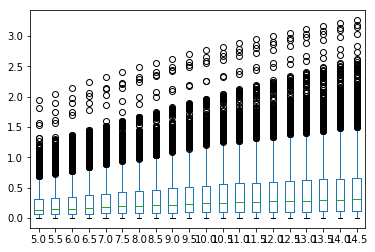

In [321]:
df.T.plot.box()
plt.show()

In [316]:
df2=pd.DataFrame(times,index=forces)
df2.T.describe()

,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,-0.052636,-0.077313,-0.093174,-0.105452,-0.109975,-0.114114,-0.117948,-0.121469,-0.124752,-0.127826,-0.130715,-0.133438,-0.136011,-0.138450,-0.140767,-0.142971,-0.145073,-0.147081,-0.149001,-0.150842
std,0.173763,0.123309,0.083145,0.050567,0.049917,0.049397,0.048985,0.048533,0.048108,0.047705,0.047320,0.046949,0.046591,0.046245,0.045910,0.045583,0.045266,0.044956,0.044655,0.044360
min,-0.266367,-0.267561,-0.268622,-0.269574,-0.270436,-0.271221,-0.271940,-0.272604,-0.273219,-0.273790,-0.274323,-0.274823,-0.275292,-0.275734,-0.276151,-0.276546,-0.276921,-0.277277,-0.277616,-0.277939
25%,-0.126664,-0.132172,-0.137077,-0.142216,-0.146683,-0.150567,-0.154053,-0.157173,-0.160119,-0.162853,-0.165221,-0.167523,-0.169770,-0.172006,-0.174270,-0.176175,-0.178056,-0.179885,-0.181717,-0.183222
50%,-0.086242,-0.093437,-0.098925,-0.104254,-0.109916,-0.114459,-0.118184,-0.121549,-0.124959,-0.128294,-0.131289,-0.134239,-0.137309,-0.139974,-0.142332,-0.144813,-0.147004,-0.149106,-0.151233,-0.153414
75%,-0.044402,-0.055487,-0.061767,-0.066621,-0.070715,-0.075788,-0.079391,-0.083108,-0.087090,-0.090325,-0.093457,-0.096544,-0.099638,-0.102425,-0.104937,-0.107072,-0.109588,-0.111969,-0.113958,-0.116083
max,0.880242,0.706922,0.542758,0.038021,0.013722,0.002059,-0.004374,-0.010368,-0.015973,-0.021231,-0.026177,-0.030843,-0.035255,-0.039437,-0.043408,-0.047186,-0.050788,-0.054226,-0.057513,-0.060661


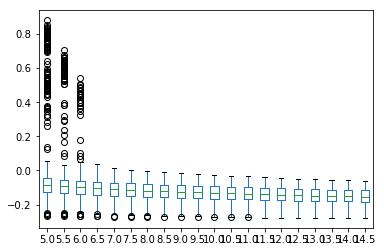

In [317]:
df2.T.plot.box()
plt.show()

In [299]:
df2Means=df2.T.mean()

In [300]:
df2Means

5.0    -0.146502
5.5    -0.157016
6.0    -0.164284
6.5    -0.170747
7.0    -0.176484
7.5    -0.181791
8.0    -0.186562
8.5    -0.190975
9.0    -0.195078
9.5    -0.198909
10.0   -0.202498
10.5   -0.205873
11.0   -0.209056
11.5   -0.212065
12.0   -0.214917
12.5   -0.217625
13.0   -0.220203
13.5   -0.222661
14.0   -0.225009
14.5   -0.227254
dtype: float64

In [247]:
def path_bis(a,b,v,tf):
    Fx=2*(b[0]-a[0]-v[0]*tf)/tf**2
    Fy=2*(b[1]-a[1]-v[1]*tf)/tf**2
    nb_points=100
    dt=tf/nb_points
    t=dt
    lx=[a[0]]
    ly=[a[1]]
    for i in range(nb_points+2):
        x=a[0]+v[0]*t+Fx*t**2/2
        y=a[1]+v[1]*t+Fy*t**2/2
        lx.append(x)
        ly.append(y)
        t=t+dt
    return [lx,ly,Fx,Fy]

In [252]:
def event_trajectory_error_bis(eventId,t):
    event=events[eventId]
    moments=event['moments']
    forces=[]
    error=0
        
    for mom_id in range(len(moments)-round(t/0.04)-1):
        err=0
        moment1=moments[mom_id][5]
        moment2=moments[mom_id+1][5]
        moment1f=moments[mom_id+round(t/0.04)][5]
        moment2f=moments[mom_id+round(t/0.04)+1][5]
        mom_infos=players_ball_speed_position(moment1,moment2)
        mom_infos_final=players_ball_speed_position(moment1f,moment2f)
        LX={}
        LY={}
        LXREAL={}
        LYREAL={}
        
        for player in mom_infos['team1'].keys():
            a=mom_infos['team1'][player]['xy']
            v=mom_infos['team1'][player]['v']
            b=mom_infos_final['team1'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t)
            forces.append(np.linalg.norm(np.array([Fx,Fy])))
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team2'].keys():
            a=mom_infos['team2'][player]['xy']
            v=mom_infos['team2'][player]['v']
            b=mom_infos_final['team2'][player]['xy']
            lx,ly,Fx,Fy=path_bis(a,b,v,t)
            forces.append(np.linalg.norm(np.array([Fx,Fy])))
            LX[player]=lx
            LY[player]=ly
            
        for player in mom_infos['team1'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for player in mom_infos['team2'].keys():
            LXREAL[player]=[]
            LYREAL[player]=[]
            
        for i in range(round(t/0.04)+1):
            mom1=moments[mom_id+i][5]
            mom2=moments[mom_id+i+1][5]
            mom_infos=players_ball_speed_position(mom1,mom2)
            for player in mom_infos['team1'].keys():
                LXREAL[player].append(mom_infos['team1'][player]['xy'][0])
                LYREAL[player].append(mom_infos['team1'][player]['xy'][1])
                
            for player in mom_infos['team2'].keys():
                LXREAL[player]=LXREAL[player]+[mom_infos['team2'][player]['xy'][0]]
                LYREAL[player]=LYREAL[player]+[mom_infos['team2'][player]['xy'][1]]
        
        for player in LX.keys():
            err+=one_trajectory_error(LX[player],LY[player],LXREAL[player],LYREAL[player])
        
        err=err/10
        error+=err
    error=error/(len(moments)-round(t/0.04)-1)
    forces=pd.DataFrame(forces)
    return(error,forces)

In [253]:
error,forces=event_trajectory_error_bis(0,0.4)

In [256]:
forces.describe()

,0
count,1390.000000
mean,5.074167
std,3.312939
min,0.206945
25%,2.552628
50%,4.504134
75%,6.859761
max,21.039982


In [257]:
error

11.755551753952876

## Sources 
[1] Akira Fujimura and Kokichi Sugihara. Geo- metric analysis and quantitative evaluation of sport teamwork. *Systems and Computers in Japan*, 36(6):49–58, 2005.

In [230]:
event=events[0]
event

{'eventId': '1',
 'home': {'abbreviation': 'WAS',
  'name': 'Washington Wizards',
  'players': [{'firstname': 'Drew',
    'jersey': '90',
    'lastname': 'Gooden',
    'playerid': 2400,
    'position': 'F'},
   {'firstname': 'Nene',
    'jersey': '42',
    'lastname': 'Hilario',
    'playerid': 2403,
    'position': 'F-C'},
   {'firstname': 'Kris',
    'jersey': '43',
    'lastname': 'Humphries',
    'playerid': 2743,
    'position': 'F'},
   {'firstname': 'Marcin',
    'jersey': '13',
    'lastname': 'Gortat',
    'playerid': 101162,
    'position': 'C'},
   {'firstname': 'Jared',
    'jersey': '1',
    'lastname': 'Dudley',
    'playerid': 201162,
    'position': 'G-F'},
   {'firstname': 'Ramon',
    'jersey': '7',
    'lastname': 'Sessions',
    'playerid': 201196,
    'position': 'G'},
   {'firstname': 'DeJuan',
    'jersey': '45',
    'lastname': 'Blair',
    'playerid': 201971,
    'position': 'C-F'},
   {'firstname': 'Garrett',
    'jersey': '17',
    'lastname': 'Temple',
    '